In [41]:
import pandas as pd 
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
import tqdm.notebook as tqdm

from tensorflow import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.regularizers import l1_l2
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import visualkeras

import warnings
warnings.filterwarnings('ignore')

In [42]:
f_dir = Path('dataset/femaleeyes')
m_dir = Path('dataset/maleeyes')

femaleeyes_filepaths = list(f_dir.glob(r'**/*.jpg'))
maleeyes_filepaths = list(m_dir.glob(r'**/*.jpg'))

# Mapping the labels
fm_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], femaleeyes_filepaths))
ml_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], maleeyes_filepaths))

# Paths & labels femalee eyes
fm_filepaths = pd.Series(femaleeyes_filepaths, name = 'File').astype(str)
fm_labels = pd.Series(fm_labels, name='Label')

# Paths & labels malee eyes
ml_filepaths = pd.Series(maleeyes_filepaths, name = 'File').astype(str)
ml_labels = pd.Series(ml_labels, name='Label')

# Concatenating...
femaleeyes_df = pd.concat([fm_filepaths, fm_labels], axis=1)
maleeyes_df = pd.concat([ml_filepaths, ml_labels], axis=1)

df = pd.concat([femaleeyes_df, maleeyes_df])

df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)
df.head()

,File,Label
0,dataset\femaleeyes\1269.jpg,femaleeyes
1,dataset\femaleeyes\5738.jpg,femaleeyes
2,dataset\femaleeyes\3848.jpg,femaleeyes
3,dataset\femaleeyes\7255.jpg,femaleeyes
4,dataset\femaleeyes\7513.jpg,femaleeyes


In [43]:
df.tail()

,File,Label
11520,dataset\maleeyes\5401.jpg,maleeyes
11521,dataset\maleeyes\5525.jpg,maleeyes
11522,dataset\femaleeyes\5261.jpg,femaleeyes
11523,dataset\femaleeyes\1531.jpg,femaleeyes
11524,dataset\femaleeyes\4273.jpg,femaleeyes


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11525 entries, 0 to 11524
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   File    11525 non-null  object
 1   Label   11525 non-null  object
dtypes: object(2)
memory usage: 180.2+ KB


In [45]:
df.describe()

,File,Label
count,11525,11525
unique,11525,2
top,dataset\femaleeyes\1269.jpg,maleeyes
freq,1,6323


## EDA and visualizations

Label
maleeyes      6323
femaleeyes    5202
Name: count, dtype: int64


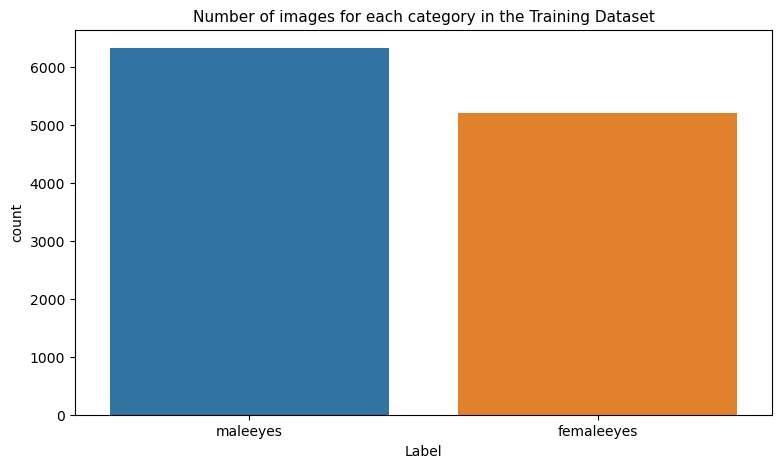

In [46]:
vc = df['Label'].value_counts()
print(vc)
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

Text(0.5, 1.0, 'maleeyes')

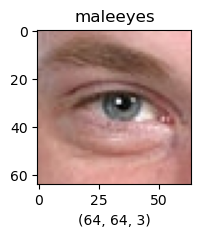

In [47]:
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["File"][34])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][34])

Text(0.5, 1.0, 'femaleeyes')

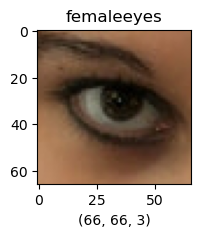

In [48]:
figure = plt.figure(figsize=(2, 2))
x = plt.imread(df["File"][11])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][11])

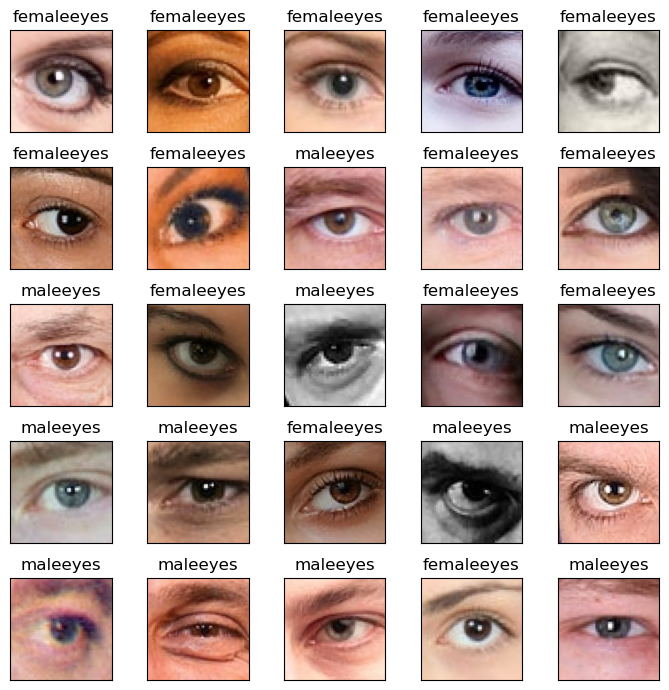

In [49]:
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

## Dividing into training and testing sets

- convert our data into training and testing sets
- 75% of the images as our training data and test our model on the remaining 25%

In [50]:
trainset_df, testset_df = train_test_split(df, train_size = 0.75, random_state = 4)

display(trainset_df.head())

testset_df.head()

,File,Label
5614,dataset\maleeyes\6300.jpg,maleeyes
862,dataset\femaleeyes\4281.jpg,femaleeyes
9030,dataset\femaleeyes\6308.jpg,femaleeyes
7482,dataset\maleeyes\5158.jpg,maleeyes
5000,dataset\maleeyes\6925.jpg,maleeyes


,File,Label
3814,dataset\femaleeyes\7267.jpg,femaleeyes
5238,dataset\femaleeyes\3224.jpg,femaleeyes
2768,dataset\femaleeyes\4134.jpg,femaleeyes
2398,dataset\maleeyes\5988.jpg,maleeyes
9093,dataset\maleeyes\7384.jpg,maleeyes


In [51]:
# Viewing data in training dataset
print('Training Dataset:')

print(f'Number of images: {trainset_df.shape[0]}')

print(f'Number of images with male eyes: {trainset_df["Label"].value_counts().iloc[0]}')
print(f'Number of images with female eyes: {trainset_df["Label"].value_counts().iloc[1]}\n')

# Viewing data in test dataset
print('Test Dataset:')

print(f'Number of images: {testset_df.shape[0]}')

print(f'Number of images with male eyes: {testset_df["Label"].value_counts().iloc[0]}')
print(f'Number of images with female eyes: {testset_df["Label"].value_counts().iloc[1]}\n')


Training Dataset:
Number of images: 8643
Number of images with male eyes: 4729
Number of images with female eyes: 3914

Test Dataset:
Number of images: 2882
Number of images with male eyes: 1594
Number of images with female eyes: 1288



In [52]:
# Get index of male and female eye
xx = df[df['Label'] == 'femaleeyes'].index[0] # index of female eye
xy = df[df['Label'] == 'maleeyes'].index[0] # index of male eye

In [53]:
# Checking image size
female_eye_size = plt.imread(df["File"][xx])
print(female_eye_size.shape, '==>',  df['Label'][xx])

male_eye_size = plt.imread(df["File"][xy])
print(male_eye_size.shape, '==>',  df['Label'][xy])

(51, 51, 3) ==> femaleeyes
(56, 56, 3) ==> maleeyes


In [54]:
# Check how many different sized images are there

size_list=set() # empty set for checking total different sizes of images

for x in range(len(df['File'])):
    size_list.add(plt.imread(df["File"][x]).shape)

print(len(size_list))
print('Smallest size :', list(sorted(size_list))[0])
print('Largest size :', list(sorted(size_list))[-1])

66
Smallest size : (41, 41, 3)
Largest size : (117, 117, 3)


The dataset contains images with 66 different sizes, ranging from 41x41 to 117x117. We will now resize them to 64x64 size.

In [55]:
# Convert image path to array of image using cv2
size = (64,64)
df1 = df.copy()

size_list = set()
for i in range(len(df)):
    image=cv2.imread(df['File'][i])
    image=cv2.resize(image,size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    size_list.add(image.shape)
    df1['File'][i] = image.flatten()

In [56]:
# check shape after resizing 

size_list

{(64, 64, 3)}

Now all the images have same size ==> 64x64, and falttened 

In [57]:
# converting the Label to a numeric format for testing later...
LE = LabelEncoder()

df1['Label'] = np.asarray(LE.fit_transform(df1["Label"]))

display(df1.head(10))

,File,Label
0,"[249, 206, 190, 247, 205, 188, 247, 203, 187, ...",0
1,"[155, 81, 32, 155, 81, 32, 157, 82, 33, 162, 8...",0
2,"[200, 160, 134, 198, 158, 132, 200, 158, 131, ...",0
3,"[204, 187, 205, 201, 184, 202, 198, 181, 199, ...",0
4,"[138, 134, 125, 115, 111, 102, 98, 93, 86, 99,...",0
5,"[128, 90, 69, 100, 63, 42, 93, 56, 37, 108, 76...",0
6,"[251, 178, 145, 250, 177, 144, 249, 175, 142, ...",0
7,"[203, 142, 137, 204, 143, 138, 205, 144, 139, ...",1
8,"[241, 209, 194, 242, 209, 194, 243, 207, 191, ...",0
9,"[231, 174, 155, 229, 172, 153, 227, 171, 151, ...",0


In [58]:
display(df1.tail(10))

,File,Label
11515,"[213, 202, 184, 212, 201, 183, 203, 191, 174, ...",0
11516,"[150, 100, 73, 154, 105, 77, 161, 109, 82, 167...",0
11517,"[146, 146, 146, 142, 142, 142, 147, 147, 147, ...",0
11518,"[253, 254, 249, 253, 254, 249, 254, 254, 249, ...",0
11519,"[212, 167, 144, 223, 178, 155, 226, 179, 157, ...",0
11520,"[249, 178, 158, 251, 183, 162, 254, 188, 166, ...",1
11521,"[188, 141, 123, 188, 141, 122, 188, 140, 120, ...",1
11522,"[236, 192, 157, 241, 197, 162, 246, 203, 168, ...",0
11523,"[226, 145, 89, 229, 150, 93, 234, 154, 101, 23...",0
11524,"[219, 169, 142, 222, 172, 145, 219, 169, 146, ...",0



##  Model 1 - Benchmark model (SVM or KNN Classifier from Sklearn)

In [59]:
## Fuction to reset the index and reshape the array 

def cleaned(X):
    for i in range(len(X)):
        X[i] = np.vstack(X[i].reset_index(drop = True))
    return X   

In [60]:
# Split data into train and test
X_train1, X_test1,y_train1, y_test1 = train_test_split(df1.File, df1.Label, test_size = 0.2, random_state = 7)

X_train1, X_test1,y_train1, y_test1 = cleaned([X_train1, X_test1,y_train1, y_test1])

print(X_train1.shape, X_test1.shape)
print(y_train1.shape, y_test1.shape)


(9220, 12288) (2305, 12288)
(9220, 1) (2305, 1)


In [61]:
#Applying KNN multiple times to find best value of K

error_rate = []
acc = []

for i in range(1,5):
 
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train1,y_train1)
    pred_i = knn.predict(X_test1)
    error_rate.append(np.mean(pred_i != y_test1))

In [62]:
# NOW WITH K=16
KNN = KNeighborsClassifier(n_neighbors=20)
KNN.fit(X_train1,y_train1)
knn_pred = KNN.predict(X_test1)

In [63]:
print('KNN Accuracy: %.3f' % accuracy_score(y_test1,knn_pred))

KNN Accuracy: 0.810


In [64]:
# Classification report
KNN_Classification_Report = classification_report(y_test1,knn_pred)
print(KNN_Classification_Report)

              precision    recall  f1-score   support

           0       0.87      0.70      0.78      1078
           1       0.78      0.91      0.84      1227

    accuracy                           0.81      2305
   macro avg       0.82      0.80      0.81      2305
weighted avg       0.82      0.81      0.81      2305



- our KNN classifier demonstrates a solid performance. It exhibits an accuracy of approximately 81%, indicating that it correctly predicts the class labels for 81% of the samples.
- The precision and recall for both classes (0 and 1) are relatively high, with values ranging from 78% to 87%, suggesting that the model effectively distinguishes between the two classes. 
- Additionally, the F1-score, which combines precision and recall, is around 0.81, indicating a good balance between precision and recall. Overall, the classifier performs well across multiple evaluation metrics, highlighting its effectiveness in classifying the data.

## Model 2 - Multilayer Perceptron Model

In [65]:
X_train2, X_val2, y_train2, y_val2 = train_test_split(df1.File, df1.Label, test_size = 0.4, random_state = 7)
X_val2, X_test2,y_val2, y_test2 = train_test_split(X_val2, y_val2, test_size = 0.5, random_state = 7)

x_train2, x_val2, x_test2, y_train2, y_val2, y_test2 = cleaned([X_train2, X_val2, X_test2, y_train2, y_val2, y_test2])

print("X_Train: ", x_train2.shape) 
print("X_Val: ", x_val2.shape) 
print("X_Test: ", x_test2.shape) 
print("y_Train: ", y_train2.shape) 
print("y_Val: ", y_val2.shape) 
print("y_test: ", y_test2.shape) 

X_Train:  (6915, 12288)
X_Val:  (2305, 12288)
X_Test:  (2305, 12288)
y_Train:  (6915, 1)
y_Val:  (2305, 1)
y_test:  (2305, 1)


The architecture is a simple feedforward neural network, also known as a Multilayer Perceptron (MLP). 

1. **Input Layer (implicit)**:
   - The input layer is determined by the shape input data `x_train2`. Each neuron in this layer represents a feature in your input data.

2. **Hidden Layers**:
   - There are two hidden layers in this MLP, each consisting of densely connected neurons (`Dense` layers). 
   - The first hidden layer has 1024 neurons, and the second hidden layer has 512 neurons. The choice of these numbers can be arbitrary or based on empirical testing.
   - The activation function used in both hidden layers is Leaky ReLU (`tf.nn.leaky_relu`). Leaky ReLU is chosen for its ability to mitigate the vanishing gradient problem by allowing a small, non-zero gradient when the input is negative.

3. **Dropout Layers**:
   - Dropout layers are inserted after each hidden layer. Dropout is a regularization technique used to prevent overfitting. It randomly sets a fraction of input units to zero during training, which helps prevent neurons from becoming overly dependent on each other.
   - In this architecture, a dropout rate of 0.5 is used, meaning each neuron has a 50% chance of being dropped out during training.

4. **Flatten Layer**:
   - After the second dropout layer, a flatten layer is used. This layer reshapes the 2D output of the previous layer into a 1D array, which can be fed into the subsequent fully connected layers (such as the output layer).

5. **Output Layer**:
   - The output layer consists of a single neuron with a sigmoid activation function. Since we're dealing with a binary classification problem , a single neuron with a sigmoid activation is implemented. The sigmoid function squashes the output between 0 and 1, providing a probability-like output which can be interpreted as the likelihood of the input belonging to one of the classes.

6. **Compilation**:
   - The model is compiled using the Adam optimizer, which is a popular choice for gradient-based optimization algorithms.
   - Binary cross-entropy is used as the loss function, which is suitable for binary classification tasks.
   - Accuracy is chosen as the evaluation metric.

7. **Training**:
   - The model is trained for 20 epochs with a batch size of 64.
   - Early stopping is implemented with a patience of 10 epochs, meaning training will stop if the validation loss doesn't improve for 10 consecutive epochs.

Overall, this architecture learns complex patterns in the data while mitigating overfitting through dropout regularization.

In [66]:
MLP = tf.keras.models.Sequential([
    # keras.layers.Input(shape=input_shape),  # Input layer
    keras.layers.Dense(1024, activation=tf.nn.leaky_relu),  # First hidden layer
    keras.layers.Dropout(0.5),  # Dropout layer to prevent overfitting
    keras.layers.Dense(512, activation=tf.nn.leaky_relu),  # Second hidden layer
    keras.layers.Dropout(0.5),  # Dropout layer
    keras.layers.Flatten(),  # Flatten layer
    keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

In [67]:
# Compile the model
MLP.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [68]:
# Training 
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train2)
mlp_history = MLP.fit(x_train_scaled, y_train2, batch_size=64,validation_data=(x_val2,y_val2),epochs=20)

Epoch 1/20
109/109 [==============================] - 14s 120ms/step - loss: 6.6448 - accuracy: 0.7177 - val_loss: 181.6019 - val_accuracy: 0.7440
Epoch 2/20
109/109 [==============================] - 13s 118ms/step - loss: 3.3675 - accuracy: 0.7892 - val_loss: 122.0564 - val_accuracy: 0.7505
Epoch 3/20
109/109 [==============================] - 13s 116ms/step - loss: 2.0133 - accuracy: 0.8082 - val_loss: 125.1999 - val_accuracy: 0.7297
Epoch 4/20
109/109 [==============================] - 13s 115ms/step - loss: 1.3803 - accuracy: 0.8162 - val_loss: 32.6585 - val_accuracy: 0.8139
Epoch 5/20
109/109 [==============================] - 13s 115ms/step - loss: 0.8289 - accuracy: 0.8354 - val_loss: 55.1852 - val_accuracy: 0.7388
Epoch 6/20
109/109 [==============================] - 13s 119ms/step - loss: 0.6284 - accuracy: 0.8438 - val_loss: 68.8057 - val_accuracy: 0.6278
Epoch 7/20
109/109 [==============================] - 14s 127ms/step - loss: 0.4670 - accuracy: 0.8502 - val_loss: 18.677

In [76]:
# Evaluate model
x_test_scaled = scaler.fit_transform(x_test2)
score = MLP.evaluate(x_test_scaled, y_test2, verbose=0)
print('Test loss:', score[0])

print('Test accuracy:', score[1])

Test loss: 0.33889010548591614
Test accuracy: 0.865075945854187


In [77]:
# Predictions 
y_pred2 = MLP.predict(x_test_scaled)
y_pred2 = np.where(y_pred2 > 0.5, 1, 0)

73/73 [==============================] - 0s 7ms/step


Text(0.5, 1.0, 'Accuracy')

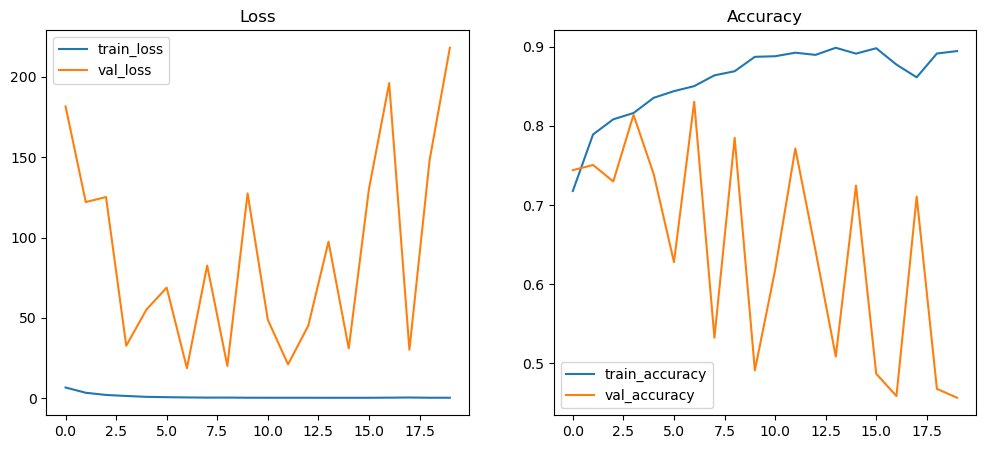

In [78]:
# make two plots of loss and accuracy versus epochs

plt.figure(figsize=(12, 5))
subplot = plt.subplot(1, 2, 1)
subplot.plot(mlp_history.history['loss'], label='train_loss')
subplot.plot(mlp_history.history['val_loss'], label='val_loss')
subplot.legend()
subplot.set_title('Loss')

subplot = plt.subplot(1, 2, 2)
subplot.plot(mlp_history.history['accuracy'], label='train_accuracy')
subplot.plot(mlp_history.history['val_accuracy'], label='val_accuracy')
subplot.legend()
subplot.set_title('Accuracy')

In [79]:
# Classification report
MLP_Classification_Report = classification_report(y_test2,y_pred2)
print(MLP_Classification_Report)

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1071
           1       0.90      0.84      0.87      1234

    accuracy                           0.87      2305
   macro avg       0.87      0.87      0.86      2305
weighted avg       0.87      0.87      0.87      2305



1. **Overall Performance**:
   - The model achieves an overall accuracy of 87%, indicating that it correctly predicts the class for a significant portion of the dataset.
   - The weighted average of precision, recall, and F1-score is also 87%, suggesting a balanced performance across both classes.

2. **Class-specific Performance**:
   - For class 0 (label 0), the model achieves a precision of 83% and a recall of 89%. This indicates that while the model correctly identifies a large portion of the instances belonging to class 0, there are some instances of misclassification.
   - For class 1 (label 1), the model achieves a slightly higher precision of 90% but a slightly lower recall of 84%. This suggests a similar performance to class 0, with some misclassifications as well.

3. **F1-score**:
   - The F1-score, which balances precision and recall, is relatively high for both classes, with values of 0.86 for class 0 and 0.87 for class 1. This suggests that the model maintains a good balance between minimizing false positives and false negatives for both classes.

4. **Insights**:
   - The model appears to generalize well to unseen data, as indicated by its high accuracy and balanced performance across classes.
   - However, there might be some room for improvement in correctly identifying instances of both classes, as evidenced by the slightly lower recall values compared to precision values.
   - Depending on the specific requirements of the application, further optimization of the model, such as tuning hyperparameters, exploring different architectures, or increasing the diversity and quantity of training data, could potentially lead to even better performance.

In summary, while the current model demonstrates solid performance on the classification task, there are opportunities for refinement to potentially enhance its accuracy and robustness further.

## Creating Directory of training, validation and test images

In [73]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [74]:
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 32)

print('Data generators are ready!')

Preparing the training dataset ...
Found 7779 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 864 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 2882 validated image filenames belonging to 2 classes.
Data generators are ready!


In [75]:
print("Training: ")
print(training_set.class_indices)
print(training_set.image_shape)
print("---" * 8)
print("Validation: ")
print(validation_set.class_indices)
print(validation_set.image_shape)
print("---" * 8)
print("Test: ")
print(test_set.class_indices)
print(test_set.image_shape)

Training: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)
------------------------
Validation: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)
------------------------
Test: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)
